In [1]:
from calendar import month, week
from datetime import timedelta, datetime
from tkinter import NS
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils.payoff_function import calculate_option_price,calculate_r
from utils.evaluation import evaluate_option_price
from utils.simulation_function import SimMultiGBMAV,SimMultiGBM
from utils.extract_data_function import extract_data
from utils.counting_days_function import days
from utils.ems_correction import EMSCorrection
from utils.calculate_implied_volatility import cov_actual_IV,cov_estimated_IV
from dateutil.relativedelta import relativedelta
import math
import warnings
warnings.filterwarnings("ignore")

## Simulation

date_to_predict: 2022-08-19 00:00:00
hist_end: 2022-08-18 00:00:00
end_date: 2022-11-04 00:00:00
q2_to_maturity: 127
q3_to_maturity: 65
q2: 2023-02-20 00:00:00
q3: 2023-05-19 00:00:00
total_trading_days: 254
holidays: ['2022-09-05', '2022-11-24', '2022-12-26', '2023-01-01', '2023-01-16', '2023-02-20', '2023-04-07', '2023-05-29', '2023-07-04']
trading_days_to_simulate: 254
Derivative Price for 2022-08-19 00:00:00
975.9132339394134
trading_days_to_simulate: 253
Derivative Price for 2022-08-22 00:00:00
947.0086377651799
trading_days_to_simulate: 252
Derivative Price for 2022-08-23 00:00:00
922.0601530924388
trading_days_to_simulate: 251
Derivative Price for 2022-08-24 00:00:00
920.346618755067
trading_days_to_simulate: 250
Derivative Price for 2022-08-25 00:00:00
917.0918861857672
trading_days_to_simulate: 249
Derivative Price for 2022-08-26 00:00:00
943.1337481998033
trading_days_to_simulate: 248
Derivative Price for 2022-08-29 00:00:00
861.0639520662387
trading_days_to_simulate: 247
Der

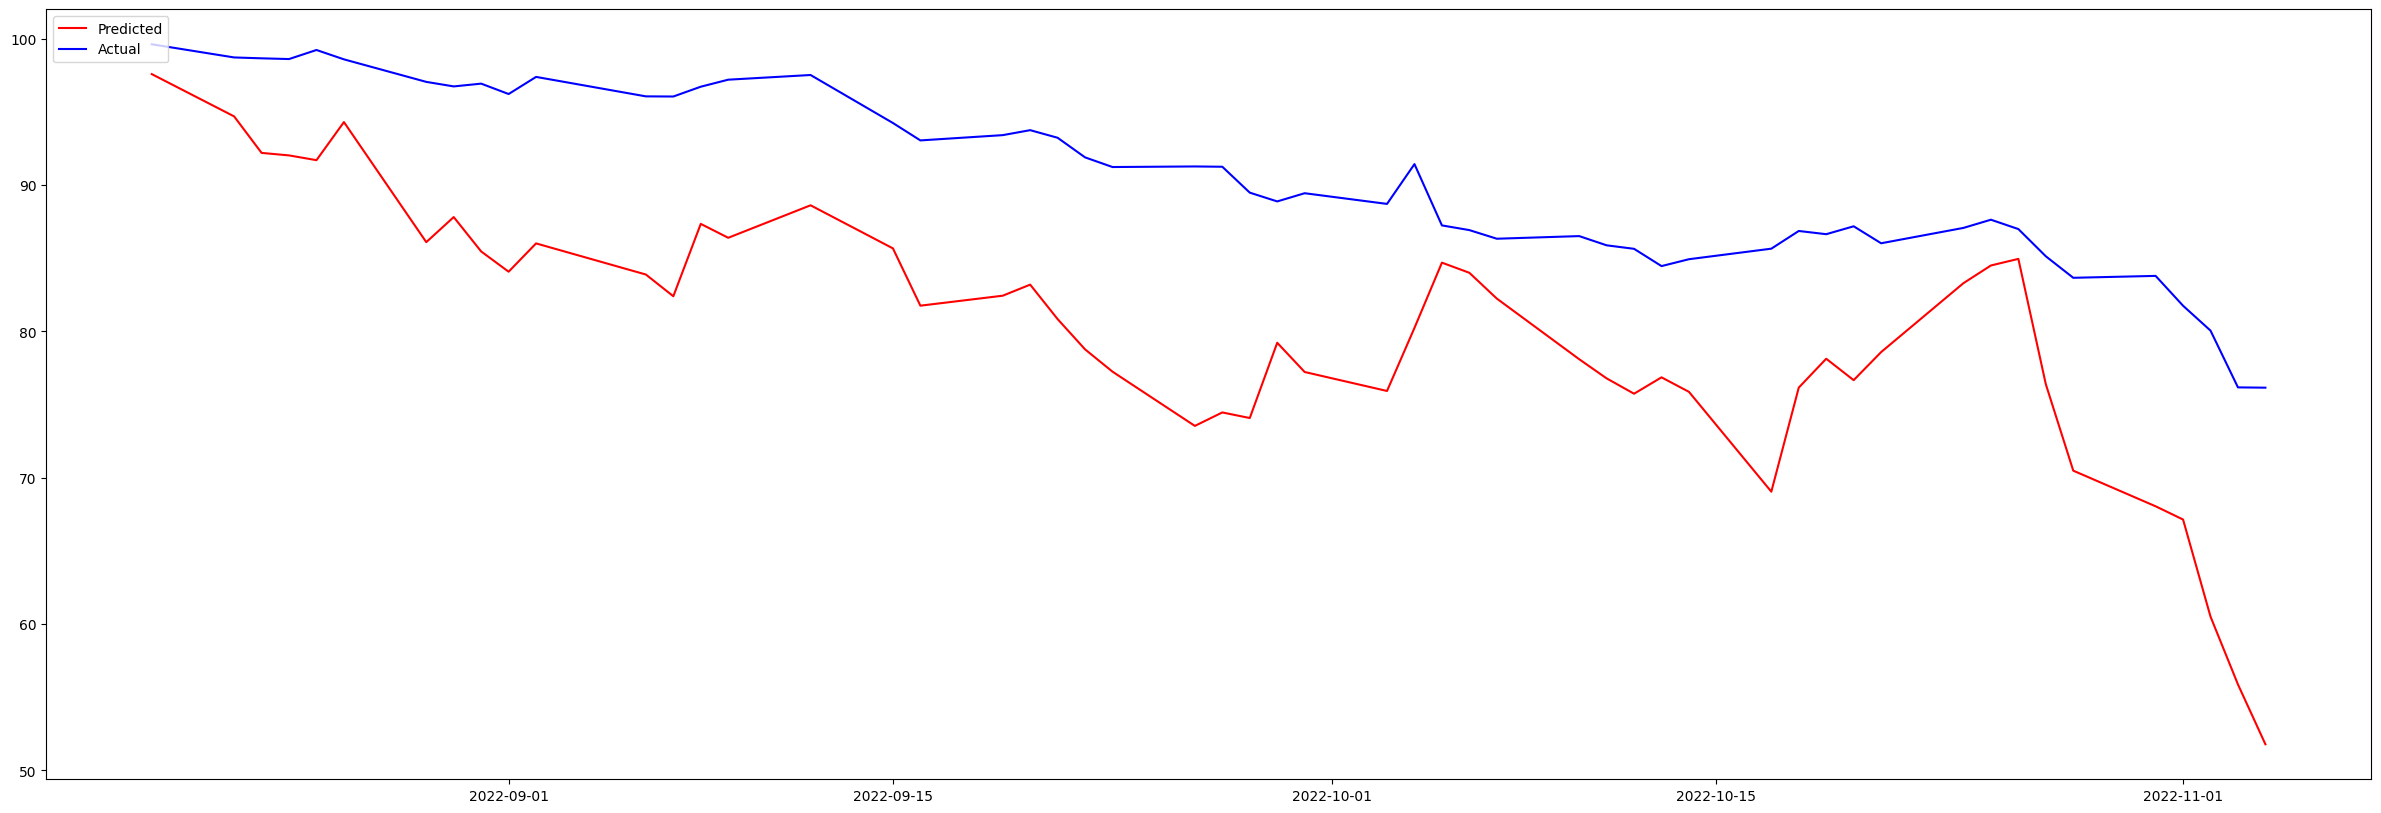

In [20]:
experiment_details = {
    'Nsim': 1000,
    'latest_price_date': '2022-11-04',
    'variance_reduction': True,
    'GBM': 'multivariate',
    'r': 0.0326,
    ## If set to true uses estimated IV calculated from BS Pricing formula
    'estimated_IV': False,
    ## If set to true uses IV data extracted from bloomberg
    'actual_IV':False,
    'min_sigma':0,
    'max_sigma':5,
    'step':0.000001,
    'EMS': False,
    'interpolate_r':False
}

aapl_barrier = 85.760
amzn_barrier = 69.115
googl_barrier = 58.605
aapl_initial = 171.52
amzn_initial = 138.23
google_initial = 117.21

date_to_predict, hist_end, end_date, q2_to_maturity, q3_to_maturity, q2, q3, total_trading_days, alternative_option_ttm, holidays = days(
    latest_price_date=experiment_details['latest_price_date'])

print(f"date_to_predict: {date_to_predict}")
print(f"hist_end: {hist_end}")
print(f"end_date: {end_date}")
print(f"q2_to_maturity: {q2_to_maturity}")
print(f"q3_to_maturity: {q3_to_maturity}")
print(f"q2: {q2}")
print(f"q3: {q3}")
print(f"total_trading_days: {total_trading_days}")
print(f"holidays: {holidays}")
trading_days_to_simulate = total_trading_days

if experiment_details['estimated_IV']:

    aapl_call_df = pd.read_csv('../Bloomberg_Data/aapl_call.csv')
    aapl_call_df['Date'] = pd.to_datetime(aapl_call_df['Date'])
    amzn_call_df = pd.read_csv('../Bloomberg_Data/amzn_call.csv')
    amzn_call_df['Date'] = pd.to_datetime(amzn_call_df['Date'])
    googl_call_df = pd.read_csv('../Bloomberg_Data/googl_call.csv')
    googl_call_df['Date'] = pd.to_datetime(googl_call_df['Date'])
    aapl_IV_list = []
    amzn_IV_list = []
    googl_IV_list = []

    min_sigma = experiment_details['min_sigma']
    max_sigma = experiment_details['max_sigma']
    step = experiment_details['step']
    sigma_hat_list = np.arange(min_sigma,max_sigma+step,step)
    right = len(sigma_hat_list)-1
    left = 0 

if experiment_details['actual_IV']:
    aapl_IV_df = pd.read_csv('../Bloomberg_Data/aapl_IV.csv')
    aapl_IV_df['Date']= pd.to_datetime(aapl_IV_df['Date'],format='%Y-%m-%d')
    amzn_IV_df = pd.read_csv('../Bloomberg_Data/amzn_IV.csv')
    amzn_IV_df['Date'] = pd.to_datetime(amzn_IV_df['Date'],format='%Y-%m-%d')
    googl_IV_df = pd.read_csv('../Bloomberg_Data/googl_IV.csv')
    googl_IV_df['Date'] = pd.to_datetime(googl_IV_df['Date'],format='%Y-%m-%d')

predicted_option_price = []
expected_payoff_list = []
sigma_list = []

while date_to_predict <= end_date:

    if datetime.strftime(date_to_predict,"%Y-%m-%d") in holidays or date_to_predict.weekday() == 5 or date_to_predict.weekday() == 6:
        date_to_predict += relativedelta(days=+1)
        hist_end += relativedelta(days=+1)
        continue

    hist_start = hist_end - timedelta(days=365)

    aapl = extract_data('../data/04-11-2022/aapl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AAPL'})
    amzn = extract_data('../data/04-11-2022/amzn_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'AMZN'})
    googl = extract_data('../data/04-11-2022/googl_04_11_2022.csv', hist_start, hist_end).rename(columns={'Close/Last': 'GOOGL'})
    temp_df = aapl.merge(amzn, on=['Date'])
    AAG = temp_df.merge(googl, on=['Date']).drop(columns=['Unnamed: 0'])
    n0 = len(AAG)
    AAGprices = np.array(AAG.drop(columns=['Date']))
    AAGlogprices = np.log(AAGprices)
    AAGlogreturns = AAGlogprices[:n0 - 1, :] - AAGlogprices[1:, :]

    v = np.mean(AAGlogreturns, axis=0)
    Nsim = experiment_details['Nsim']
    T = trading_days_to_simulate
    dt = 1
    m = int(T / dt)
    r = experiment_details['r'] if 'r' in experiment_details else calculate_r(0, date_to_predict, interpolate_r=False)

    # If IV setting is true covariance matrix is calculated from implied volatility of individual stocks  options market price
    if experiment_details['estimated_IV']:
        sigma= cov_estimated_IV(aapl_call_df,amzn_call_df,googl_call_df,r,alternative_option_ttm,sigma_hat_list,left,right,date_to_predict,AAGlogreturns)

    elif experiment_details['actual_IV']:
        sigma = cov_actual_IV(aapl_IV_df,amzn_IV_df,googl_IV_df,date_to_predict,AAGlogreturns)
        
    else:
        sigma = np.cov(AAGlogreturns,rowvar=False)

    sigma_list.append(np.append(np.sqrt(sigma.diagonal()),datetime.strftime(date_to_predict,'%Y-%m-%d')))

    print(f"trading_days_to_simulate: {trading_days_to_simulate}")

    S0 = AAGprices[0, :]
    sim_aapl = []
    sim_amzn = []
    sim_googl = []
    random.seed(4518)

    # Antithetic Variate reduction technique is applied if Variance Reduction is set to true
    if experiment_details['variance_reduction']:
        for i in range(1, int(Nsim/2) + 1):
            S, Stilde = SimMultiGBMAV(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_aapl.append(Stilde[0])
            sim_amzn.append(S[1])
            sim_amzn.append(Stilde[1])
            sim_googl.append(S[2])
            sim_googl.append(Stilde[2])

    else:
        for i in range(1, Nsim + 1):
            S,Z = SimMultiGBM(S0, v, sigma, dt, T)
            sim_aapl.append(S[0])
            sim_amzn.append(S[1])
            sim_googl.append(S[2])

    if experiment_details['EMS']:
        sim_aapl = EMSCorrection(sim_aapl,Nsim,r,dt,T)
        sim_amzn = EMSCorrection(sim_amzn,Nsim,r,dt,T)
        sim_googl = EMSCorrection(sim_googl,Nsim,r,dt,T)

    q2_index = total_trading_days - q2_to_maturity if total_trading_days - q2_to_maturity>=0 else None
    q3_index = total_trading_days - q3_to_maturity if total_trading_days - q3_to_maturity>=0 else None

    option_prices = []
    payoff_list = []
    for i in range(Nsim):
        option_price, payoff, r = calculate_option_price(
                aapl=sim_aapl[i],
                amzn=sim_amzn[i],
                googl=sim_googl[i],
                T=trading_days_to_simulate,
                total_trading_days=total_trading_days,
                q2_index=q2_index,
                q3_index=q3_index,
                q2=q2,
                q3=q3,
                maturity=datetime.strptime('2023-08-22',"%Y-%m-%d"),
                cur=date_to_predict,
                interpolate_r=experiment_details['interpolate_r'],
                r=experiment_details['r'] if 'r' in experiment_details else None

            )
        option_prices.append(
            option_price
        )
        payoff_list.append(payoff)
        

    expected_payoff_list.append(np.mean(payoff_list))
    option_price = np.mean(option_prices)
    predicted_option_price.append({'date':date_to_predict, 'predicted': option_price})
    print(f"Derivative Price for {date_to_predict}")
    print(option_price)

    date_to_predict += relativedelta(days=+1)
    trading_days_to_simulate -= 1
    hist_end += relativedelta(days=+1)
    alternative_option_ttm-=1


predicted_option_price = pd.DataFrame(predicted_option_price)
predicted_option_price['date'] = pd.to_datetime(predicted_option_price['date'])
# Scale back to 100%
predicted_option_price['predicted'] = predicted_option_price['predicted']/10
actual_option_price = pd.read_csv('../data/04-11-2022/derivative_04_11_2022.csv')
actual_option_price['date'] = pd.to_datetime(actual_option_price['date'], format='%Y-%m-%d')
combined = predicted_option_price.merge(actual_option_price, left_on=['date'], right_on=['date'], validate='one_to_one')
combined = combined.set_index('date')


evaluate_option_price(combined['predicted'], combined['value'], expected_payoff_list, experiment_details)

## Visualisation

## Implied Volatility vs Historical Volatility Visualisation

In [21]:
historical_vol = sigma_list

In [22]:
hist_vol_df = pd.DataFrame(historical_vol,columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
hist_vol_df['Type'] = 'Historical Volatility'

In [18]:
estimated_IV = sigma_list

In [19]:
estimated_IV_df = pd.DataFrame(estimated_IV,columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
estimated_IV_df['Type'] = 'Estimated IV'

In [15]:
actual_IV = sigma_list

In [16]:
actual_IV_df = pd.DataFrame(actual_IV,columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
actual_IV_df['Type'] = 'Actual IV'

In [23]:
pdList = [hist_vol_df,estimated_IV_df,actual_IV_df]
merged_vol_df = pd.DataFrame(columns=['AAPL_Vol','AMZN_Vol','GOOGL_Vol','Date'])
merged_vol_df = pd.concat(pdList,axis=0)

In [24]:
merged_vol_df

,AAPL_Vol,AMZN_Vol,GOOGL_Vol,Date,Type
0,0.01916335495836022,0.027641208400446197,0.02095638755311791,2022-08-19,Historical Volatility
1,0.01924703511344626,0.027776422488322086,0.021043304673032247,2022-08-22,Historical Volatility
2,0.019267366341435728,0.027815085732463357,0.021060157562546665,2022-08-23,Historical Volatility
3,0.01922958148071035,0.0277606588750618,0.02101876293330044,2022-08-24,Historical Volatility
4,0.019229656652301218,0.027748933229995866,0.02101022036490459,2022-08-25,Historical Volatility
...,...,...,...,...,...
50,0.02193694197173133,0.026770811512447406,0.023368881285535985,2022-10-31,Actual IV
51,0.021814866077905008,0.02612111295507347,0.02320709577837324,2022-11-01,Actual IV
52,0.021624491340710362,0.026131161786228665,0.02295319107286535,2022-11-02,Actual IV
53,0.021959536953166058,0.02631163858691256,0.0227998236183309,2022-11-03,Actual IV


In [25]:
temp = merged_vol_df.copy()
temp['AAPL_Vol'] = temp['AAPL_Vol'].astype('float')
temp['AMZN_Vol'] = temp['AMZN_Vol'].astype('float')
temp['GOOGL_Vol'] = temp['GOOGL_Vol'].astype('float')

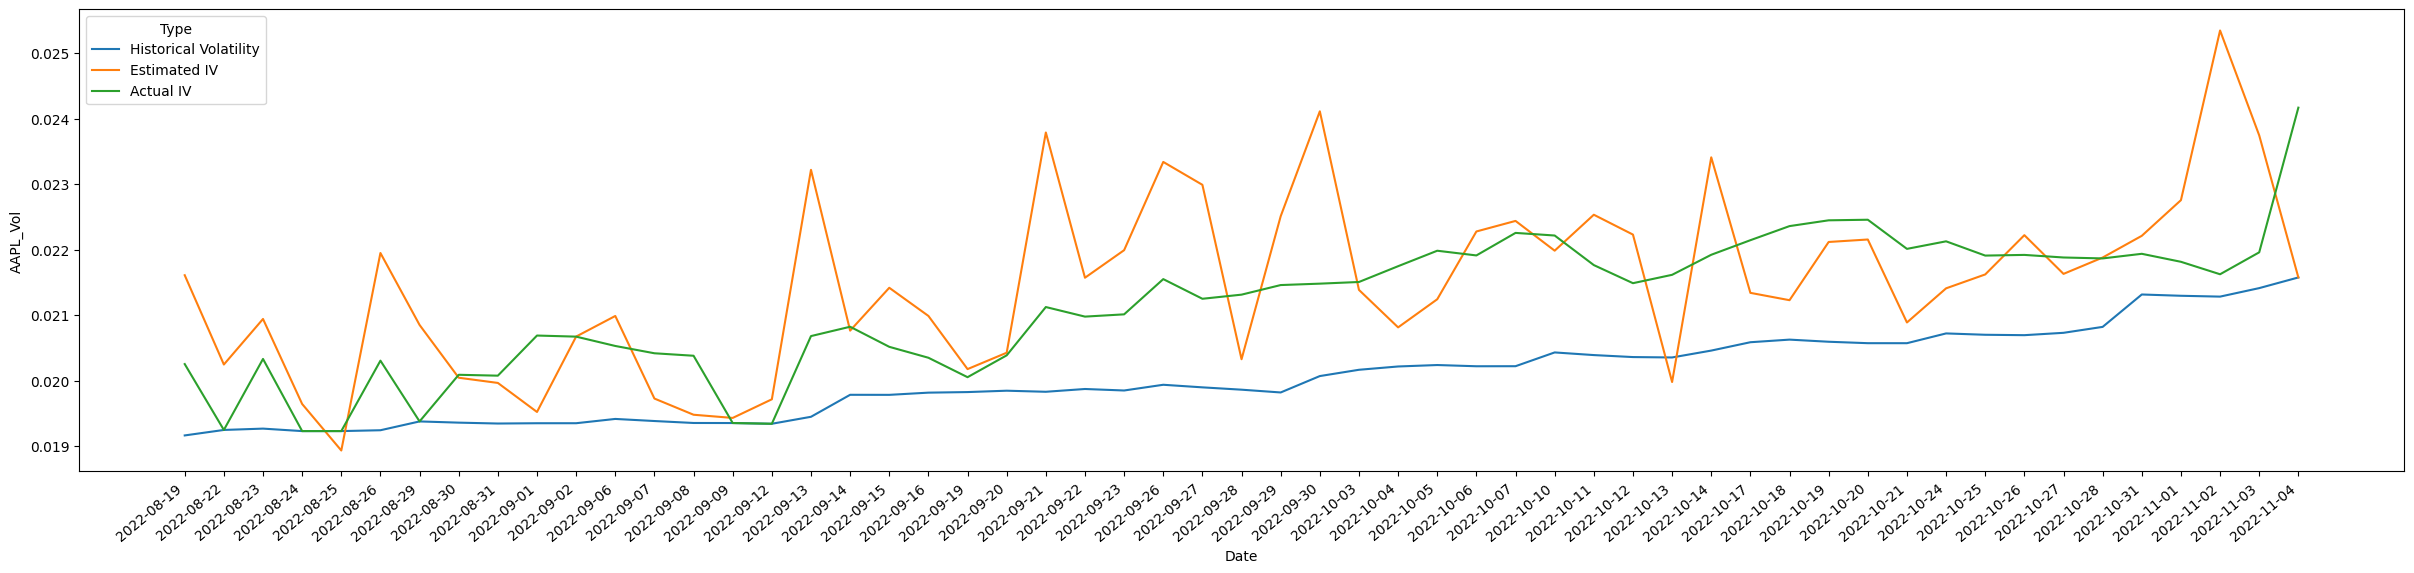

In [35]:
import seaborn as sns
fig= plt.figure(figsize=(30,6))

ax = sns.lineplot(x='Date',y='AAPL_Vol',data=temp,hue='Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('../results/AAPL_Vol')

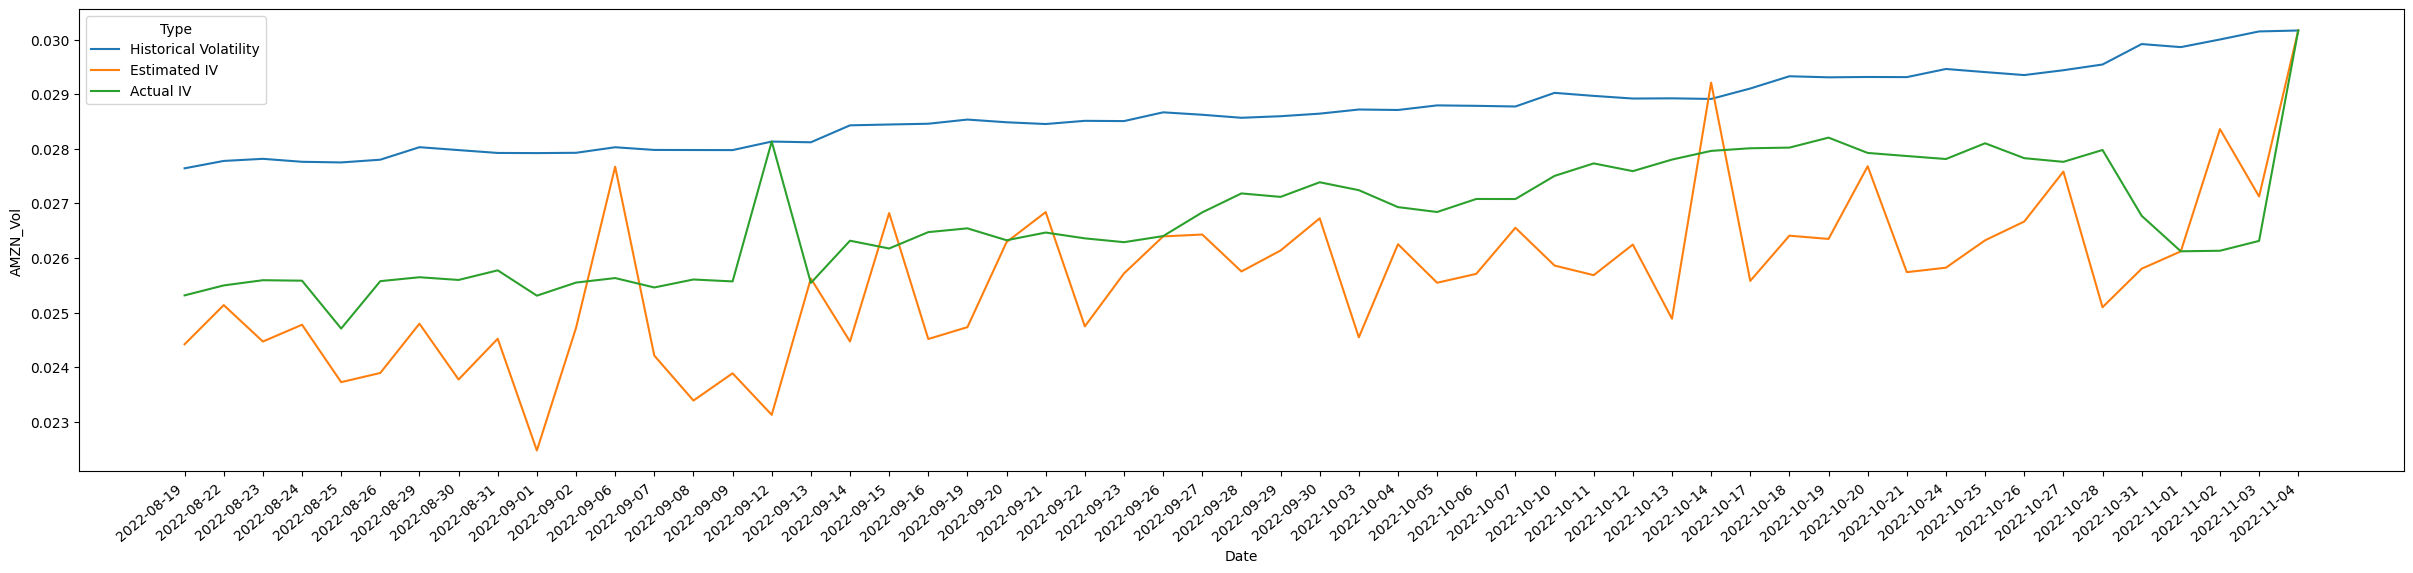

In [36]:
fig= plt.figure(figsize=(30,6))

ax = sns.lineplot(x='Date',y='AMZN_Vol',data=temp,hue='Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('../results/AMZN_Vol')



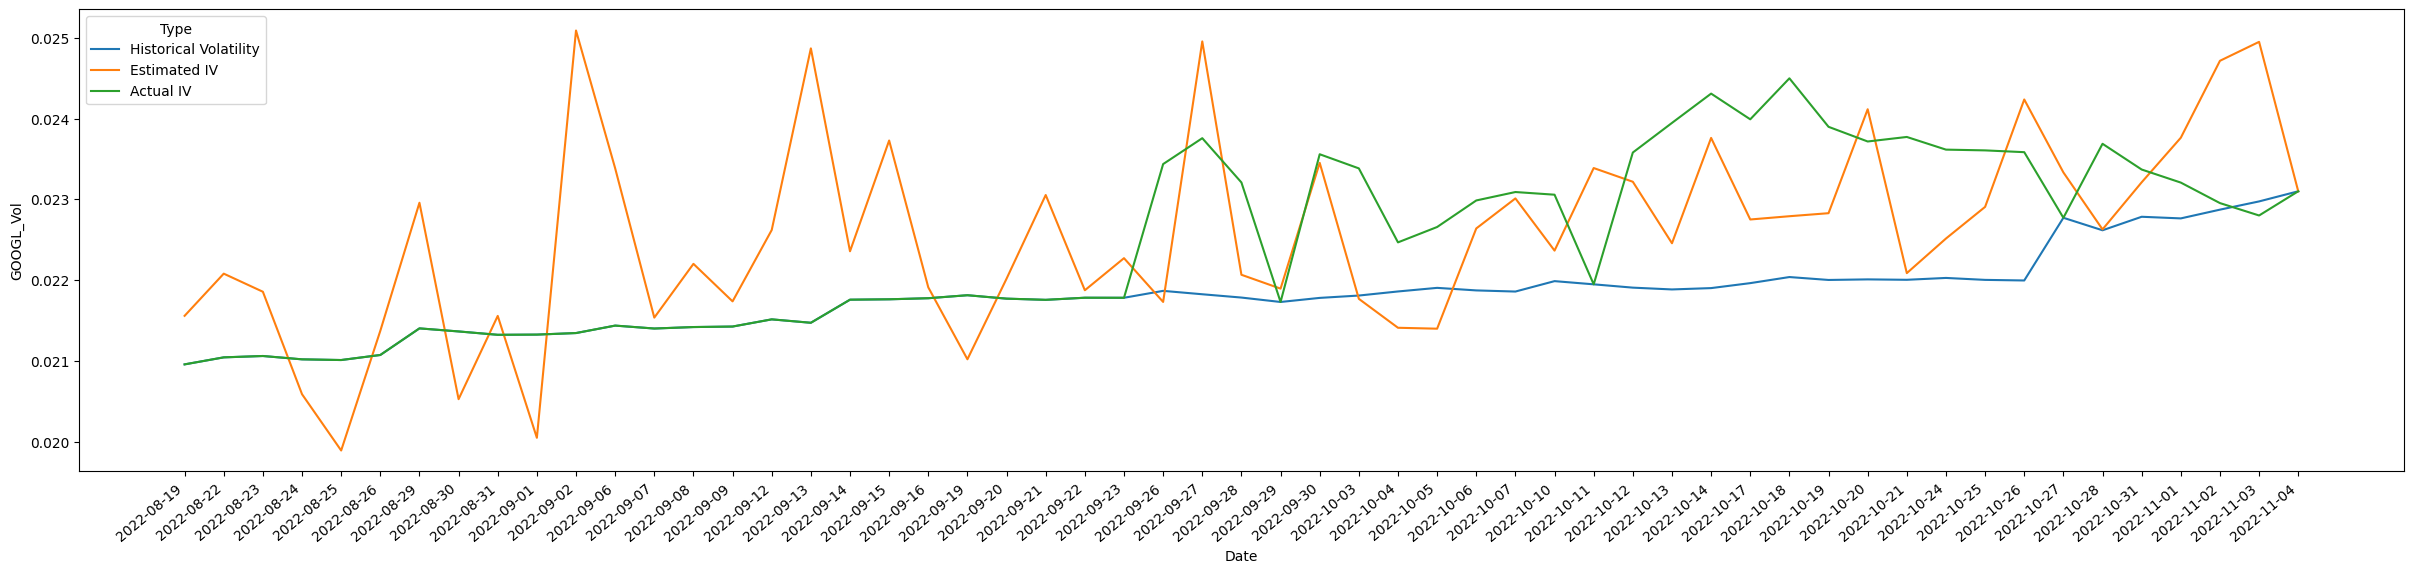

In [37]:
fig= plt.figure(figsize=(30,6))

ax = sns.lineplot(x='Date',y='GOOGL_Vol',data=temp,hue='Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('../results/GOOGL_Vol')


In [56]:
hist_vol_df

,AAPL_Vol,AMZN_Vol,GOOGL_Vol,Date,Type
0,0.01916335495836022,0.027641208400446197,0.02095638755311791,2022-08-19,Historical Volatility
1,0.01924703511344626,0.027776422488322086,0.021043304673032247,2022-08-22,Historical Volatility
2,0.019267366341435728,0.027815085732463357,0.021060157562546665,2022-08-23,Historical Volatility
3,0.01922958148071035,0.0277606588750618,0.02101876293330044,2022-08-24,Historical Volatility
4,0.019229656652301218,0.027748933229995866,0.02101022036490459,2022-08-25,Historical Volatility
5,0.019242586647724696,0.02779904389611082,0.02107271276024505,2022-08-26,Historical Volatility
6,0.019377113132912332,0.028028256382238503,0.021402065752030006,2022-08-29,Historical Volatility
7,0.019358644123560753,0.027974964695660055,0.02136417654022312,2022-08-30,Historical Volatility
8,0.01934512520289324,0.027922764462255063,0.021322580742309825,2022-08-31,Historical Volatility
9,0.019349591169401766,0.027919985690513877,0.021325070050693704,2022-09-01,Historical Volatility


In [58]:
actual_IV_df

,AAPL_Vol,AMZN_Vol,GOOGL_Vol,Date,Type
0,0.020252994202751052,0.025313946862503628,0.02095638755311791,2022-08-19,Actual IV
1,0.01924703511344626,0.025496294115190762,0.021043304673032247,2022-08-22,Actual IV
2,0.0203314052535113,0.025591415174231427,0.021060157562546665,2022-08-23,Actual IV
3,0.01922958148071035,0.02558281972048386,0.02101876293330044,2022-08-24,Actual IV
4,0.019229656652301218,0.024705971579587892,0.02101022036490459,2022-08-25,Actual IV
5,0.02030517982384899,0.025574159506468342,0.02107271276024505,2022-08-26,Actual IV
6,0.01937711313291233,0.025645996305528444,0.021402065752030006,2022-08-29,Actual IV
7,0.020089541145563727,0.025596307518111035,0.02136417654022312,2022-08-30,Actual IV
8,0.020075964263835896,0.0257723494756176,0.021322580742309825,2022-08-31,Actual IV
9,0.020688714299618365,0.02530841280324149,0.021325070050693704,2022-09-01,Actual IV
